# Линейная регрессия: переобучение и регуляризация

Рассмотрим подробнее переобучение линейных моделей. Также разберемся как его диагностировать и контролировать.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее будем предсказывать; таким образом, будет решаться задача регрессии.

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Посмотрим на графиках, как целевой признак зависит от остальных

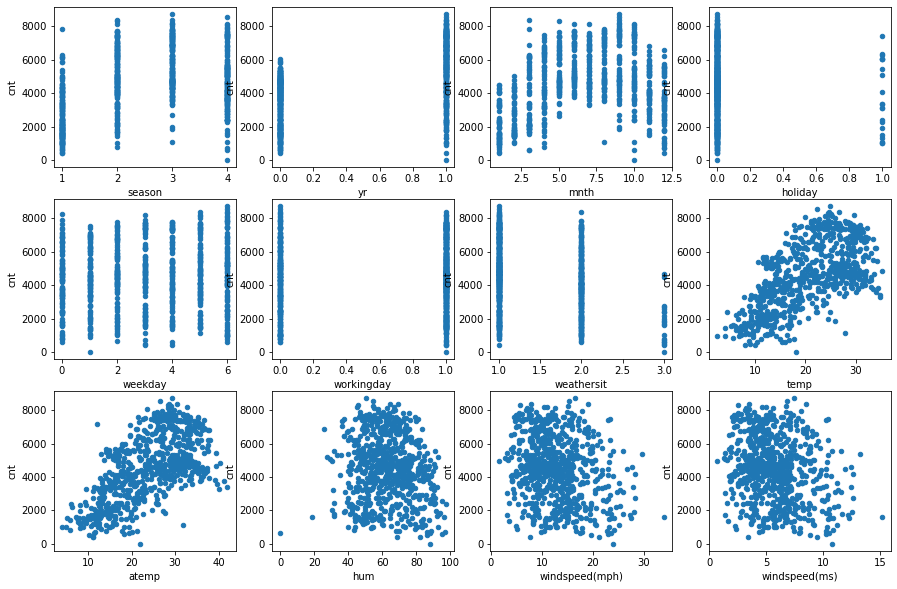

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

Сразу можно сказать, что количество прокатов увеличивается к 6-7 месяцу, затем уменьшается. К середине года (летом) спрос больше всего. Также хорошо видно, что число прокатов зависит линейно от температуры.

Оценим более строго уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона.

In [4]:
# Корреляции всех признаков с целевым
df.loc[:,df.columns[:-1]].corrwith(df.loc[:,'cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому также посчитаем корреляции между вещественными признаками.

In [5]:
# Попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
df.loc[:,df.columns[7:]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


В матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Также посмотрим средние признаков, чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [6]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но интересно посмотреть, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. 

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [8]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
zipped = zip(df.columns[:-1],linear_regressor.coef_)
list(zipped)

[('season', 570.8681698112806),
 ('yr', 1021.9637175294769),
 ('mnth', -141.30232005185658),
 ('holiday', -86.76357810238395),
 ('weekday', 137.2291962130855),
 ('workingday', 56.38823527436251),
 ('weathersit', -330.2316126526911),
 ('temp', 367.4749136050979),
 ('atemp', 585.5563613048682),
 ('hum', -145.60790584172227),
 ('windspeed(mph)', 12458830091266.607),
 ('windspeed(ms)', -12458830091465.062)]

Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такую ситуацию называют проблемой мультиколлинеарности. С парой temp-atemp такого не произошло, т.к. они чуть меньше коррелируют.

Решение проблемы мультиколлинеарности состоит в регуляризации линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором - Ridge. 

Обучим регрессоры Ridge и Lasso с параметрами по умолчанию и убедимся, что проблема с весами решилась.

In [11]:
from sklearn.linear_model import Lasso, Ridge

In [12]:
# L1-регуляризация
lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
zipped = zip(df.columns[:-1],lasso_regressor.coef_)
list(zipped)

[('season', 560.241616030887),
 ('yr', 1019.4634940657196),
 ('mnth', -128.7306270367875),
 ('holiday', -86.15278133371096),
 ('weekday', 137.34789390496329),
 ('workingday', 55.21237064135668),
 ('weathersit', -332.3698569623488),
 ('temp', 376.3632362096987),
 ('atemp', 576.5307935045507),
 ('hum', -144.12915500348595),
 ('windspeed(mph)', -197.13968940248608),
 ('windspeed(ms)', -2.8049652690829766e-08)]

In [13]:
# L2-регуляризация
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
zipped = zip(df.columns[:-1],ridge_regressor.coef_)
list(zipped)

[('season', 563.0645722520173),
 ('yr', 1018.9483787875288),
 ('mnth', -131.87332028247687),
 ('holiday', -86.74609799709266),
 ('weekday', 138.00511117871898),
 ('workingday', 55.90311037506441),
 ('weathersit', -332.3497884990723),
 ('temp', 386.4578891919361),
 ('atemp', 566.3470470600394),
 ('hum', -145.07132729867294),
 ('windspeed(mph)', -99.2594410817209),
 ('windspeed(ms)', -99.25944115441256)]

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. 

Пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ 

In [14]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучим регрессор Lasso и Ridge
# запишем веса в соответствующие строки матрицы coefs_lasso и coefs_ridge.
for id, alpha in enumerate(alphas):
    lasso_regressor = Lasso(alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso[id] = lasso_regressor.coef_
    ridge_regressor = Ridge(alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge[id] = ridge_regressor.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

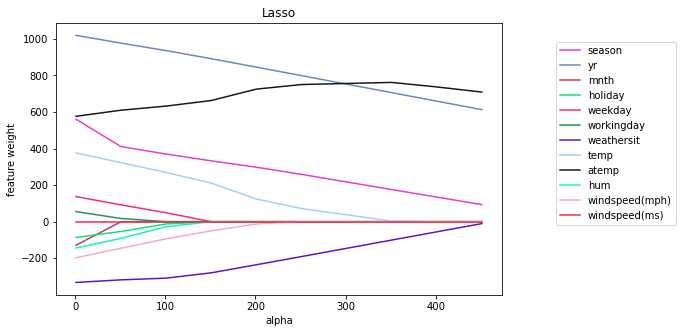

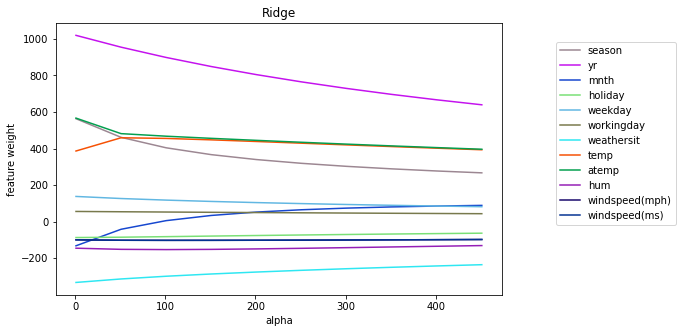

In [15]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

## Выводы

Можно заметить, что Lasso более агрессивно уменьшает веса при одном и том же alpha. При этом если alpha сделать очень большим, то все веса занулятся, т.к. при большом коэф. регуляризации в процессе минимизации функционала ошибок оптимальнее всего становится занулить сумму модулей всех весов (множитель перед alpha), соответственно модель становится слишком простой. Для отбора неинформативных признаков лучше всего подойдет Lasso.

Далее будем работать с Lasso. Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error. Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Для этого есть специальный регрессор, LassoCV, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения регрессор будет содержать переменную mse\_path\_, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_ обученные веса, соответствующие этому alpha_.

Обратим внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [16]:
from sklearn.linear_model import LassoCV

Выбранное alpha: 6
Пары признак-коэффициент:  [('season', 532.0189828413537), ('yr', 1015.0602226430597), ('mnth', -100.03952614356626), ('holiday', -83.29395987529917), ('weekday', 132.50446549095795), ('workingday', 51.55708561407389), ('weathersit', -330.5598567399813), ('temp', 370.6798550300351), ('atemp', 581.3969310654967), ('hum', -140.0074055006887), ('windspeed(mph)', -191.77140847135064), ('windspeed(ms)', -2.6854518176296607e-08)]


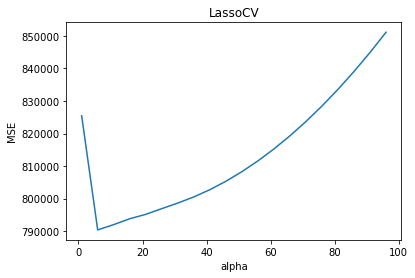

In [17]:
# Обучим регрессор LassoCV на всех параметрах регуляризации из alpha
# Построим график усредненного по строкам MSE в зависимости от alpha. 
# Выведем выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
lasso_regressorcv = LassoCV(alphas=alphas, cv=3) 
lasso_regressorcv.fit(X, y)
#Список усредненных по строкам MSE:
mse_mean = [mse_row.mean() for mse_row in lasso_regressorcv.mse_path_]
plt.plot(lasso_regressorcv.alphas_, mse_mean)
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("LassoCV")
print('Выбранное alpha:', lasso_regressorcv.alpha_)
zipped = zip(df.columns[:-1], lasso_regressorcv.coef_)
print('Пары признак-коэффициент: ',list(zipped))

Итак, мы выбрали некоторый параметр регуляризации. Теперь посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Минимум MSE на разбиении 1: 843336.18
Alpha при минимуме MSE на разбиении 1: 41
Минимум MSE на разбиении 2: 772598.5
Alpha при минимуме MSE на разбиении 2: 6
Минимум MSE на разбиении 3: 745668.61
Alpha при минимуме MSE на разбиении 3: 1


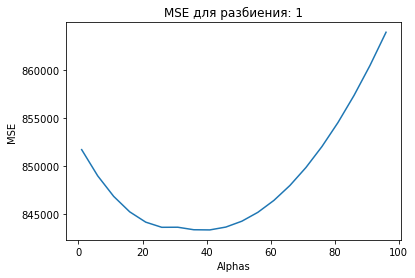

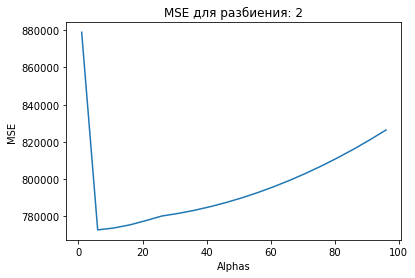

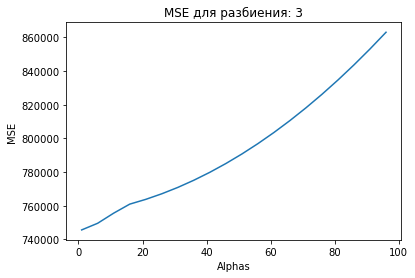

In [18]:
# Выведем значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируем столбцы .mse_path_
min_mse_list = []
alpha_min_list = []
for i in range(lasso_regressorcv.mse_path_.shape[1]):
    min_mse, ind = min((min_mse, ind) for (ind, min_mse) in enumerate(lasso_regressorcv.mse_path_[:,i])) 
    alpha_min = lasso_regressorcv.alphas_[ind]
    print('Минимум MSE на разбиении ',i+1,': ',round(min_mse, 2),sep='')
    print('Alpha при минимуме MSE на разбиении ',i+1,': ',alpha_min,sep='')
for i in range(lasso_regressorcv.mse_path_.shape[1]):
    plt.figure()
    plt.plot(lasso_regressorcv.alphas_, lasso_regressorcv.mse_path_[:,i])
    plt.xlabel("Alphas")
    plt.ylabel("MSE")
    plt.title("MSE для разбиения: " + str(i+1))

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

## Выводы

Таким образом, признакаи с наибольшими положительными весами: season, yr, temp, atemp. То есть с каждым годом число прокатов на велосипеде растет. Сезон и температура также влияют на число прокатов. 
Признаки с наибольшими отрицательными весами: weathersit, hum, windspeed(mph). Здесь также логично, что при увеличении скорости ветра, влажности или неблагоприятности погоды взять велосипеды захотят меньше людей.
Можно заметить, что признак windspeed(ms) при Lasso регуляризации вообще занулился. Модель исключила его, т.к. он является линейно-зависимым. Аналогичный признак в других единицах измерения windspeed(mph) уже учтен.